In [1]:
!nvidia-smi

Thu Sep 30 04:01:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/test.csv')

In [4]:
!mkdir images_train
!mkdir images_train/0
!mkdir images_train/1
!mkdir images_train/2
!mkdir images_train/3
!mkdir images_train/4
!mkdir images_train/5
!mkdir images_train/6
!mkdir images_train/7
!mkdir images_train/8
!mkdir images_train/9
!mkdir images_test

In [5]:
import cv2

for idx in range(len(train)) :
    img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
    digit = train.loc[idx, 'digit']
    cv2.imwrite(f'./images_train/{digit}/{train["id"][idx]}.png', img)

In [6]:
for idx in range(len(test)) :
    img = test.loc[idx, '0':].values.reshape(28, 28).astype(int)
    cv2.imwrite(f'./images_test/{test["id"][idx]}.png', img)

In [18]:
model_save = 'DenseNet169_1'
Target_model = 'DenseNet169_model'
Target_predict = 'DenseNet169_predict'
Target_acc = 'DenseNet169_acc'
Target_val = 'DenseNet169_val'

In [19]:
import tensorflow as tf
Target_model =  tf.keras.applications.DenseNet169(weights=None, include_top=True, input_shape=(224, 224, 1), classes=10)

In [20]:
Target_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator (
    rescale = 1./255, 
    validation_split = 0.075,
    rotation_range = 15,
    width_shift_range = 0.00,
    height_shift_range = 0.05 )

batch_size = 8
train_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), batch_size = batch_size, color_mode='grayscale', class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), batch_size = batch_size, color_mode='grayscale', class_mode='categorical', subset='validation')

Found 1900 images belonging to 10 classes.
Found 148 images belonging to 10 classes.


In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'/content/drive/MyDrive/DACON_CVLC/Checkpoint/'+ model_save +'.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [23]:
Target_model.fit_generator(train_generator, epochs = 500, validation_data=val_generator, callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
238/238 [==============================] - 67s 135ms/step - loss: 1.9146 - accuracy: 0.3337 - val_loss: 8.3696 - val_accuracy: 0.1081

Epoch 00001: val_accuracy improved from -inf to 0.10811, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/DenseNet169_1.h5
Epoch 2/500
238/238 [==============================] - 29s 121ms/step - loss: 1.2220 - accuracy: 0.5826 - val_loss: 3.2735 - val_accuracy: 0.2973

Epoch 00002: val_accuracy improved from 0.10811 to 0.29730, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/DenseNet169_1.h5
Epoch 3/500
238/238 [==============================] - 29s 121ms/step - loss: 0.9906 - accuracy: 0.6753 - val_loss: 1.2332 - val_accuracy: 0.6149

Epoch 00003: val_accuracy improved from 0.29730 to 0.61486, saving model to /content/drive/MyDrive/DACON_CVLC/Checkpoint/DenseNet169_1.h5
Epoch 4/500
238/238 [==============================] - 29s 120ms/step - loss: 0.8319 - accuracy: 0.7268 - val_loss: 0.6722 - val_accuracy: 0.7568

E

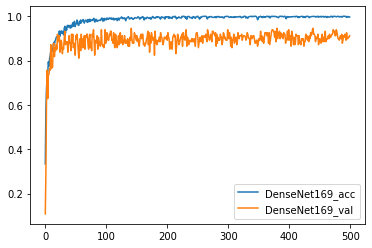

In [24]:
import matplotlib.pyplot as plt

plt.plot(Target_model.history.history["accuracy"], label = Target_acc)
plt.plot(Target_model.history.history["val_accuracy"], label = Target_val)

plt.legend()
plt.show()

In [25]:
Target_model = tf.keras.models.load_model('/content/drive/MyDrive/DACON_CVLC/Checkpoint/'+ model_save +'.h5', compile=False)

In [26]:
!mkdir images_test/none
!mv images_test/*.png images_test/none

In [27]:
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory('./images_test', target_size=(224,224), color_mode='grayscale', class_mode='categorical', shuffle=False)

Found 20480 images belonging to 1 classes.


In [28]:
Target_predict = Target_model.predict_generator(test_generator).argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [29]:
submission = pd.read_csv('/content/drive/MyDrive/DACON_CVLC/data/submission.csv')

In [30]:
import numpy as np
mylist = []

for i in range(len(submission)):
    name =  test_generator.filenames
    id = name[i].split('/')[1].rstrip('.').split('.')[0]
    mylist.append(id)

In [31]:
for i in range(len(submission)):
    submission["id"][i] = mylist[i]

In [32]:
submission["model_predict"] = Target_predict

In [33]:
from collections import Counter

for i in range(len(submission)) :
    predicts = submission.loc[i, ['model_predict']]
    submission.at[i, "digit"] = Counter(predicts).most_common(n=1)[0][0]

In [34]:
submission = submission[['id', 'digit']]

In [35]:
from google.colab import files

submission.to_csv('/content/drive/MyDrive/DACON_CVLC/Submission/'+ model_save +'.csv', index=False)
files.download('/content/drive/MyDrive/DACON_CVLC/Submission/'+ model_save +'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
!pip install /content/drive/MyDrive/DACON_submit_api/dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./drive/MyDrive/DACON_submit_api/dacon_submit_api-0.0.4-py3-none-any.whl


In [37]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
    # 파일경로
    '/content/drive/MyDrive/DACON_CVLC/Submission/'+ model_save +'.csv', 
    # d9249@kyonggi.ac.kr
    # 'c2ecc8b05a9867f71ebb86f632ae73326696cb7f6e21be07ab43a7b400ef1f11',
    # dodo9249@gmail.com
    # 'abc9927563b1882b2480ac943a313a002631fb00c5a0daea43b12720ed34114e',
    # d9249.acc001@gmail.com
    'b27d6929e0eedade68e6a882d4006ec463f061c75a81aa27561c2c606dde8ad7',
    # meanideal96@gamil.com
    # '895306aa742a46bd095afaf319bd0b9519e1e6e74f4bf98a32c2e4c15aee5026',
    # dodo402298@gmail.com
    # '384b4c250944611e49156214ca31fd554bbc64d22ec31a2726302c22f1a05271',
    # d9249.acc002@gmail.com
    # 'b28b29dd8d3ed4701f3b4e5b4d95549078e543dbd4a12abd92a3dd9a09d85616',
    # 대회 ID
    '235626',
    # d9249@kyonggi.ac.kr 팀이릉
    # 'iDeal9',
    # dodo9249@gmail.com 팀이름
    # 'iDeal96',
    # d9249.acc001@gmail.com
    'iDeal01',
    # meanideal96@gamil.com
    # 'iDeal02',
    # dodo402298@gmail.com
    # 'mean01',
    # d9249.acc002@gmail.com
    # 'mean02',
    # memo
    'd9249_kyonggi_ac_kr' )

{'isSubmitted': False, 'detail': 'Over max submission count of Daily. 일일 제출 가능한 최대 횟수가 초과 되었습니다.'}
